# Maximal lag analysis with Nexa. 
In this notebook we analyse how far in the future we can predict the next letter with the representations created from Nexa when we vary the maximal lag. 

In [1]:
import numpy as np
import h5py
from sklearn import svm, cross_validation
from sklearn.naive_bayes import MultinomialNB

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/heberto/miniconda/envs/nexa/lib/python3.5/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


#### Load all the data

In [2]:
# First we load the file 
file_location = '../results_database/text_wall_street_big.hdf5'
f = h5py.File(file_location, 'r')

# Now we need to get the letters and align them
text_directory = '../data/wall_street_letters.npy'
letters_sequence = np.load(text_directory)
Nletters = len(letters_sequence)
symbols = set(letters_sequence)

# Load the particular example
Nspatial_clusters = 8
Ntime_clusters = 40
Nembedding = 3

parameters_string = '/' + str(Nspatial_clusters)
parameters_string += '-' + str(Ntime_clusters)
parameters_string += '-' + str(Nembedding)

## Latency analysis

In [6]:
# Set the parameters for the simulation
maximal_lags = np.arange(8, 21, 3)
# Run the delay analysis
N = 1000
delays = np.arange(0, 25, 1)
accuracy_matrix = np.zeros((maximal_lags.size, delays.size))

In [7]:
for maximal_lag_index, maximal_lag in enumerate(maximal_lags):
    # Extract the appropriate database
    run_name = '/low-resolution' + str(maximal_lag)
    nexa = f[run_name + parameters_string]

    # Now we load the time and the code vectors
    time = nexa['time']
    code_vectors = nexa['code-vectors']
    code_vectors_distance = nexa['code-vectors-distance']
    code_vectors_softmax = nexa['code-vectors-softmax']
    code_vectors_winner = nexa['code-vectors-winner']

    for delay_index, delay in enumerate(delays):
        X = code_vectors_softmax[:(N - delay)]
        y = letters_sequence[delay:N]
        X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.10)

        clf = svm.SVC(C=1.0, cache_size=200, kernel='linear')
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test) * 100.0
        accuracy_matrix[maximal_lag_index, delay_index] = score
        print('delay_index', delay_index)
        print('maximal_lag_index', maximal_lag_index)
        print('maximal_lag', maximal_lag)
        print('delay', delay)
        print('score', score)
        print('-------------')



delay_index 0
maximal_lag_index 0
maximal_lag 8
delay 0
score 22.0
-------------
delay_index 1
maximal_lag_index 0
maximal_lag 8
delay 1
score 77.0
-------------
delay_index 2
maximal_lag_index 0
maximal_lag 8
delay 2
score 70.0
-------------
delay_index 3
maximal_lag_index 0
maximal_lag 8
delay 3
score 92.0
-------------
delay_index 4
maximal_lag_index 0
maximal_lag 8
delay 4
score 91.0
-------------
delay_index 5
maximal_lag_index 0
maximal_lag 8
delay 5
score 78.0
-------------
delay_index 6
maximal_lag_index 0
maximal_lag 8
delay 6
score 77.0
-------------
delay_index 7
maximal_lag_index 0
maximal_lag 8
delay 7
score 77.0
-------------
delay_index 8
maximal_lag_index 0
maximal_lag 8
delay 8
score 77.0
-------------
delay_index 9
maximal_lag_index 0
maximal_lag 8
delay 9
score 25.0
-------------
delay_index 10
maximal_lag_index 0
maximal_lag 8
delay 10
score 22.2222222222
-------------
delay_index 11
maximal_lag_index 0
maximal_lag 8
delay 11
score 18.1818181818
-------------
delay_

#### Plot it

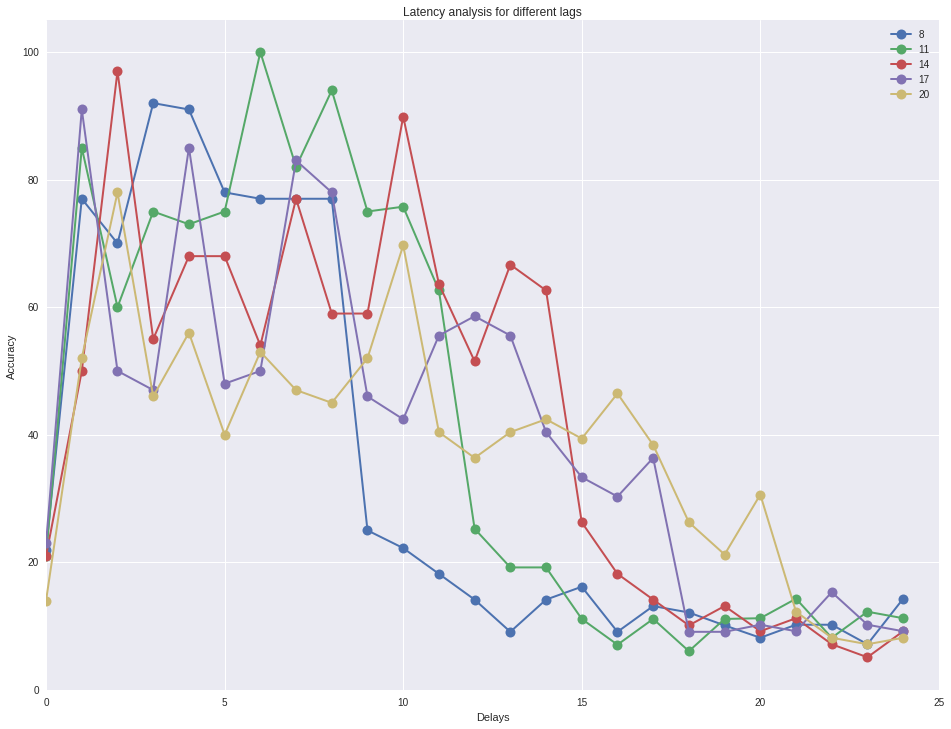

In [9]:
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
for maximal_lag_index in range(maximal_lags.size):
    ax.plot(delays, accuracy_matrix[maximal_lag_index, :], 'o-', lw=2, markersize=10,
            label=str(maximal_lags[maximal_lag_index]))

ax.set_xlabel('Delays')
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 105])
ax.set_title('Latency analysis for different lags')
ax.legend()